In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Loading Model

In [2]:
model_path = 'lenet_enhanced_rgb_aug.13-0.62.h5' # Change this accordingly
model = keras.models.load_model(model_path)

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 average_pooling2d_4 (Averag  (None, 127, 127, 16)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 average_pooling2d_5 (Averag  (None, 62, 62, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 average_pooling2d_6 (Averag  (None, 30, 30, 32)      

## Grad-cam setup

In [4]:
last_conv_layer_name = "conv2d_7" # Change this to the last conv2d layer specified in the summary above
model.layers[-1].activation = None

## Grad-cam Functions

In [5]:
def img_to_array_and_expand_dims(img):
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index

In [6]:
def create_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [7]:
def get_img_with_resize(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    return img

## Plotting grad-cam

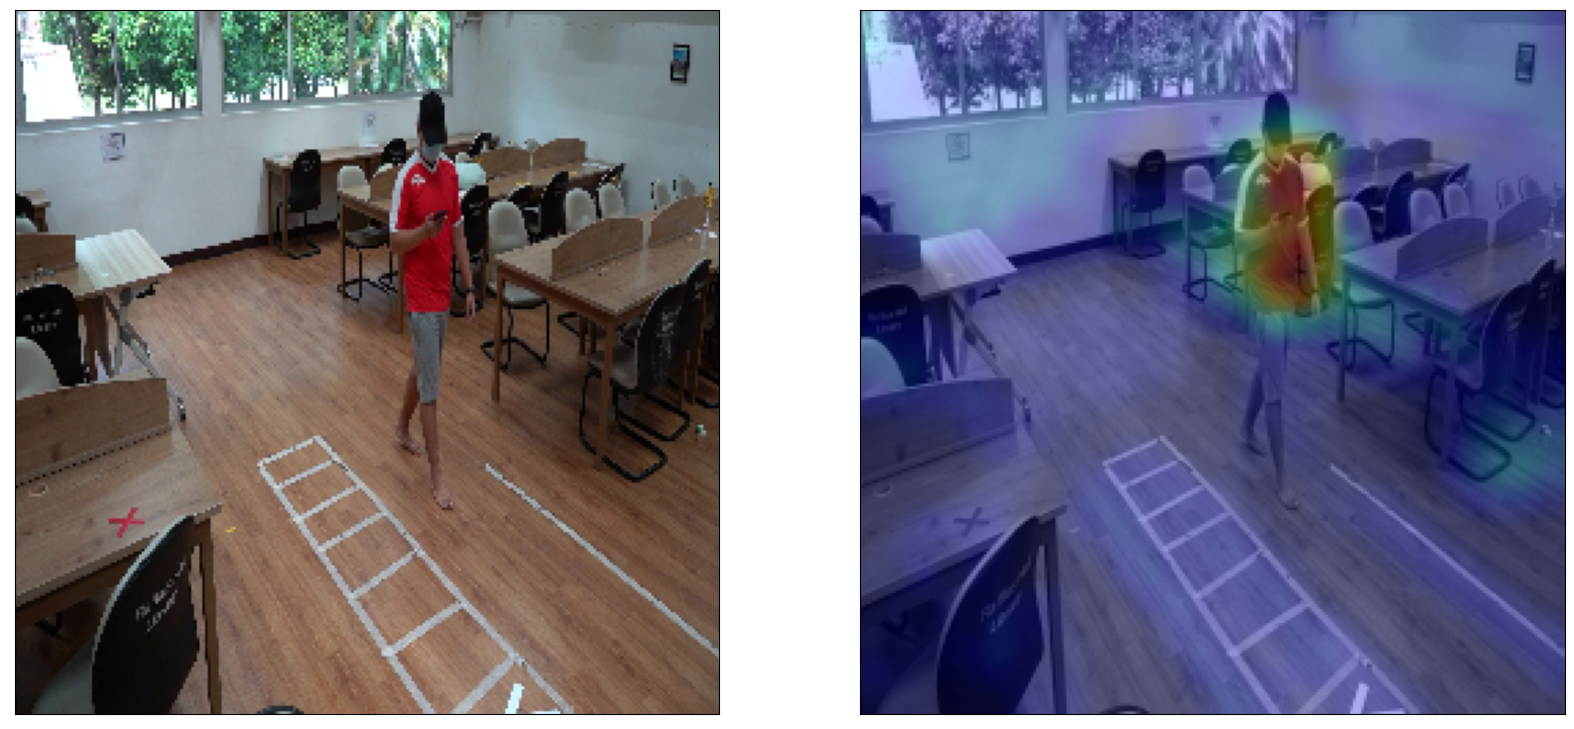

In [9]:
# Classfied correctly, predict normal, actual normal
img_path = "images/0200869_220904_normal_49120.44108_100.png"
fig,axes = plt.subplots(1,2, figsize=(20, 20))
img = get_img_with_resize(img_path, size=(256, 256))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].imshow(img)
img_array = img_to_array_and_expand_dims(img)
heatmap, pred = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img_gs = cv2.imread(img_path, 0)
img_gs = cv2.resize(img_gs, (256, 256), interpolation = cv2.INTER_AREA)
img_grad_cam = create_gradcam(img_gs, heatmap)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].imshow(img_grad_cam)

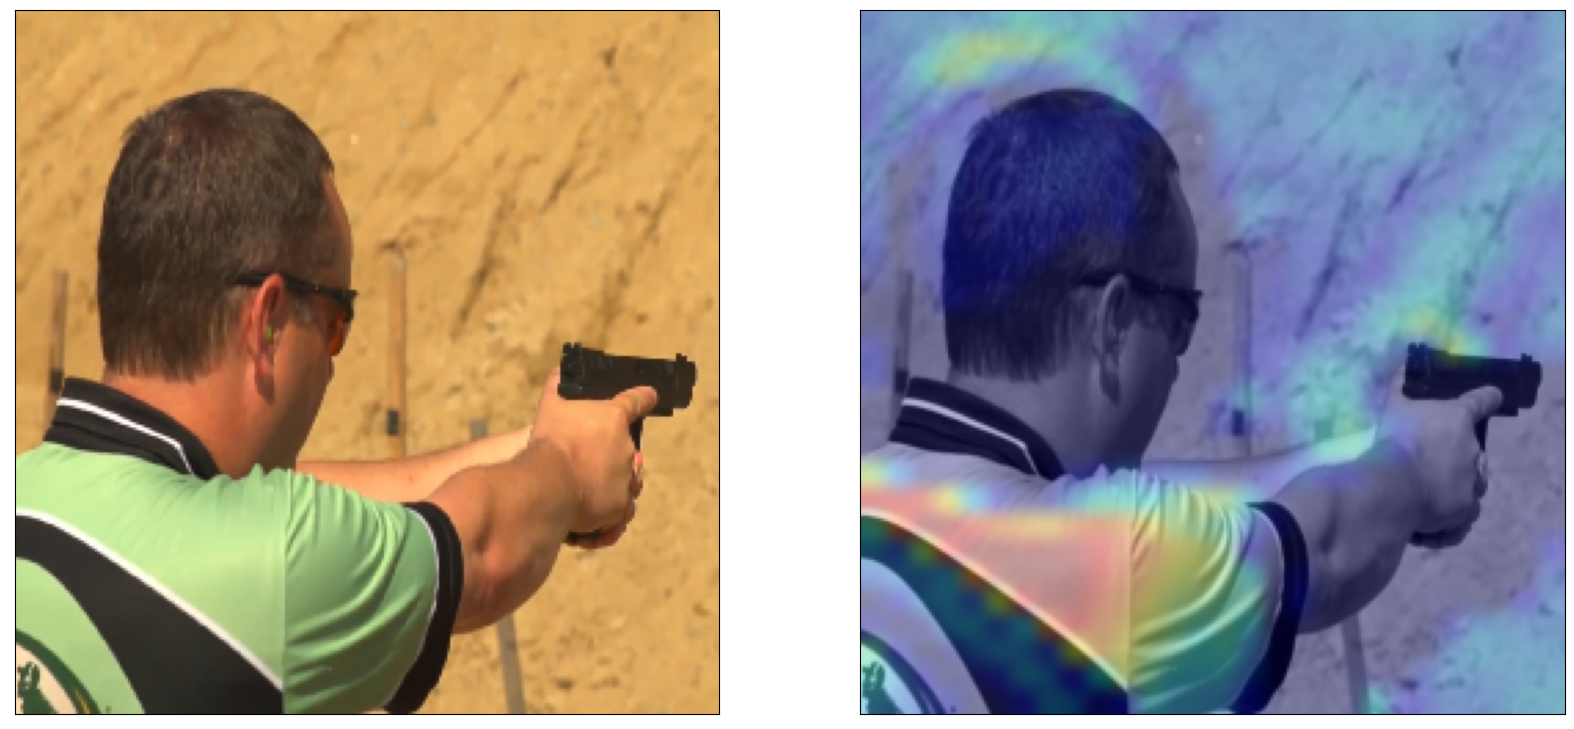

In [10]:
# Classfied correctly, predict threat, actual threat
img_path = "images/0205250_20220828_threat_39540.33627_100.png"
fig,axes = plt.subplots(1,2, figsize=(20, 20))
img = get_img_with_resize(img_path, size=(256, 256))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].imshow(img)
img_array = img_to_array_and_expand_dims(img)
heatmap, pred = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img_gs = cv2.imread(img_path, 0)
img_gs = cv2.resize(img_gs, (256, 256), interpolation = cv2.INTER_AREA)
img_grad_cam = create_gradcam(img_gs, heatmap)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].imshow(img_grad_cam)

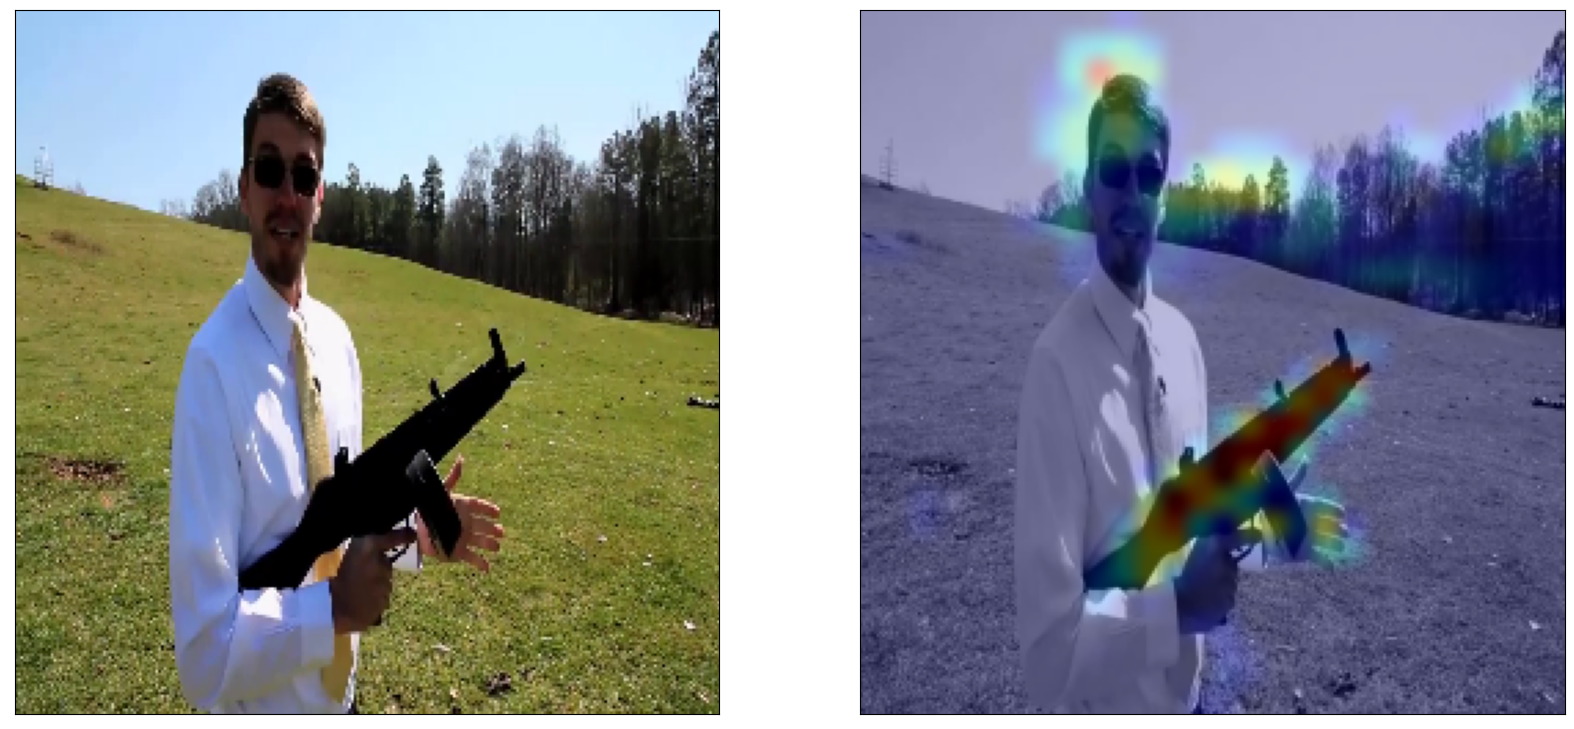

In [11]:
# Classfied correctly, predict carrying, actual carrying
img_path = "images/A0222462N_20220831_carrying_00070.19713_30.png"
fig,axes = plt.subplots(1,2, figsize=(20, 20))
img = get_img_with_resize(img_path, size=(256, 256))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].imshow(img)
img_array = img_to_array_and_expand_dims(img)
heatmap, pred = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img_gs = cv2.imread(img_path, 0)
img_gs = cv2.resize(img_gs, (256, 256), interpolation = cv2.INTER_AREA)
img_grad_cam = create_gradcam(img_gs, heatmap)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].imshow(img_grad_cam)

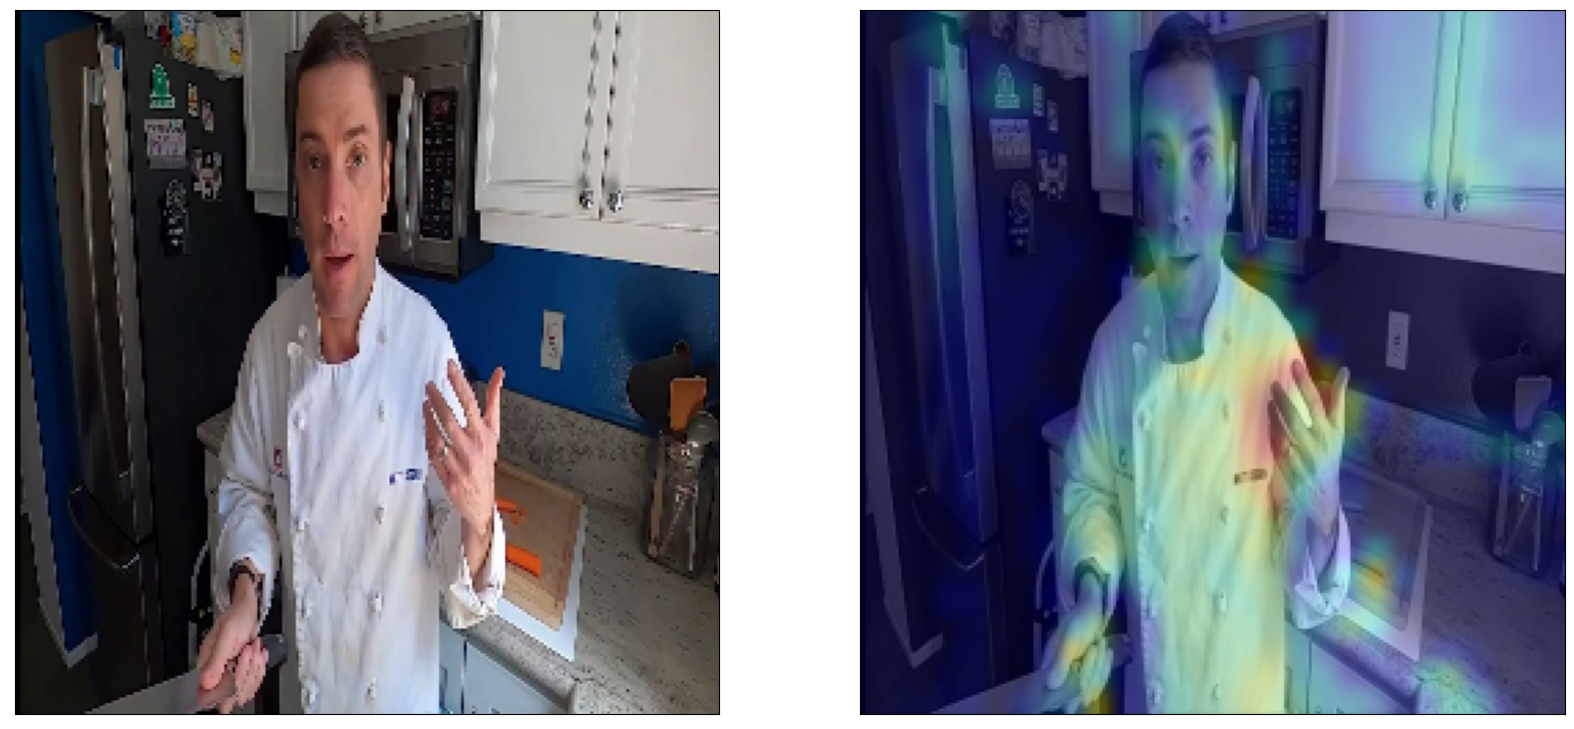

In [12]:
# Misclassfied, predict normal, actual carrying
img_path = "images/0200778_20220904_carrying_63230.034946_100.png"
fig,axes = plt.subplots(1,2, figsize=(20, 20))
img = get_img_with_resize(img_path, size=(256, 256))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].imshow(img)
img_array = img_to_array_and_expand_dims(img)
heatmap, pred = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img_gs = cv2.imread(img_path, 0)
img_gs = cv2.resize(img_gs, (256, 256), interpolation = cv2.INTER_AREA)
img_grad_cam = create_gradcam(img_gs, heatmap)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].imshow(img_grad_cam)

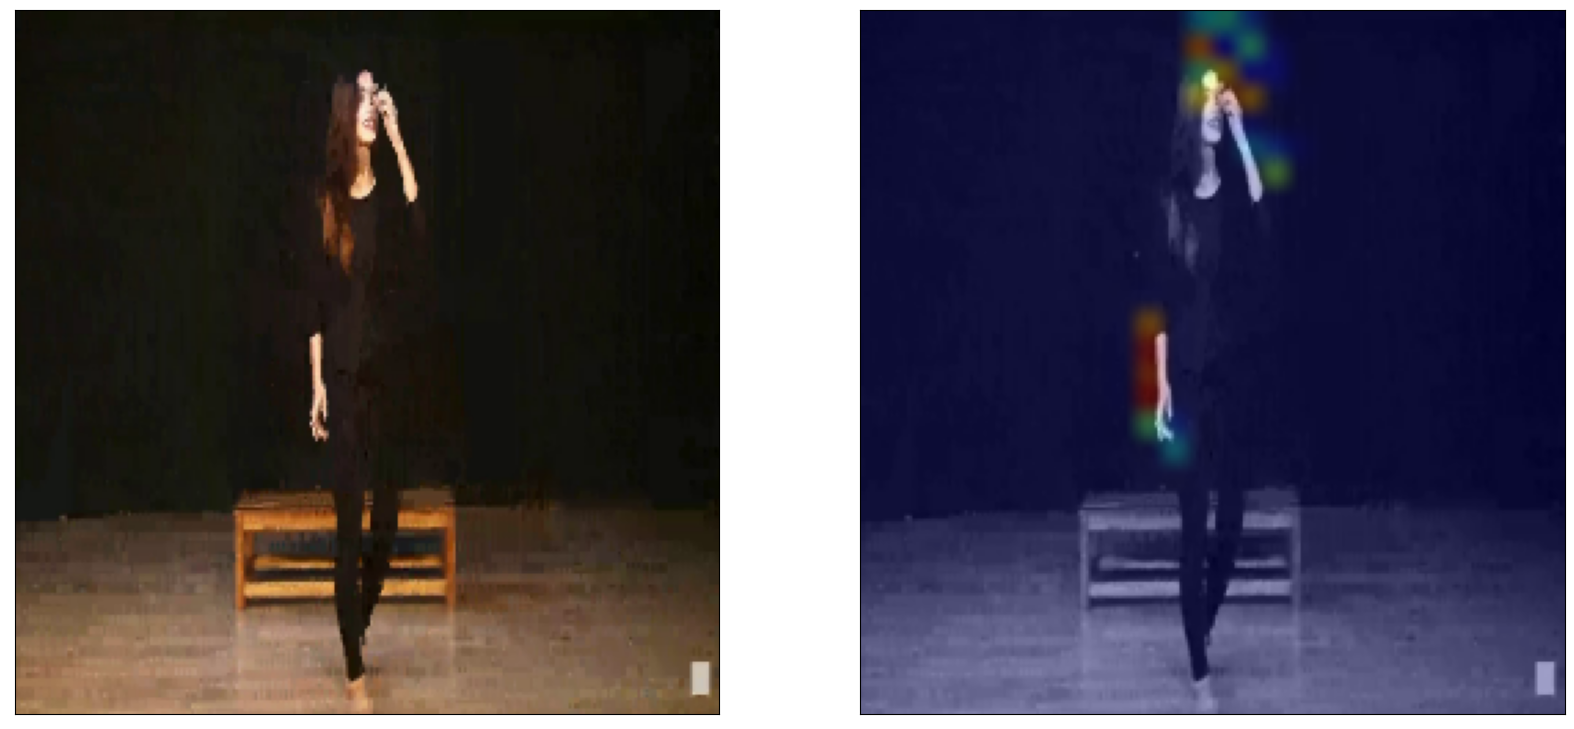

In [13]:
# Misclassfied, predict Carrying, actual normal
img_path = "images/normal100.37006_30.png"
fig,axes = plt.subplots(1,2, figsize=(20, 20))
img = get_img_with_resize(img_path, size=(256, 256))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].imshow(img)
img_array = img_to_array_and_expand_dims(img)
heatmap, pred = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img_gs = cv2.imread(img_path, 0)
img_gs = cv2.resize(img_gs, (256, 256), interpolation = cv2.INTER_AREA)
img_grad_cam = create_gradcam(img_gs, heatmap)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].imshow(img_grad_cam)

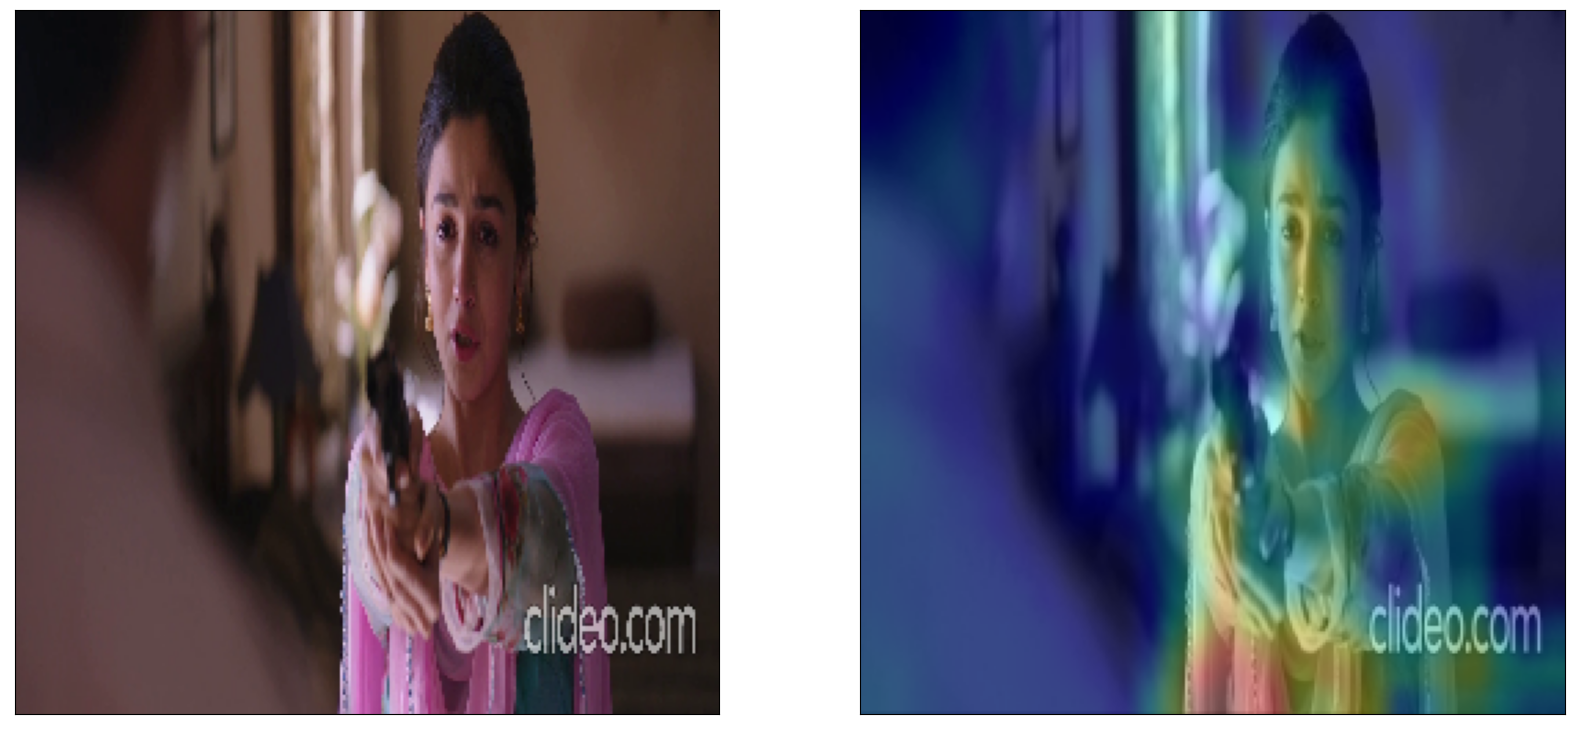

In [14]:
# Misclassfied, predict carrying, actual threat
img_path = "images/0226581_20220904_threat_00100.16595_200.png"
fig,axes = plt.subplots(1,2, figsize=(20, 20))
img = get_img_with_resize(img_path, size=(256, 256))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].imshow(img)
img_array = img_to_array_and_expand_dims(img)
heatmap, pred = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img_gs = cv2.imread(img_path, 0)
img_gs = cv2.resize(img_gs, (256, 256), interpolation = cv2.INTER_AREA)
img_grad_cam = create_gradcam(img_gs, heatmap)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].imshow(img_grad_cam)